In [1]:
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import theano as th
th.config.warn.round=False

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.width",110)
pd.set_option("display.max_columns",12)
np.set_printoptions(linewidth=110, edgeitems=6, suppress=True)

### FIT5197 Assessment 3 questions

In [ ]:
df = pd.read_csv('dataLOW3.csv')
df = df.dropna()
df['LOW'] = df['LOW'].astype(int)
df['FTV'] = df['FTV'].astype(int)
df['BWT'] = df['BWT'].astype(int)
variables = ['LOW','FTV','LWT','BWT']
df = df[variables]
df.head()
df.dtypes

np.random.seed(10)
traces = {}
ppcs = {}

In [ ]:
# define utility plotting and stats functions

def trace_stats(x):
    result = pd.DataFrame()
    hpd = pm.hpd(x, 0.05)

    result['mean'] = np.mean(x, 0)
    result['sd']   = np.std(x, 0)
    result['mc_error'] = pm.mc_error(x, len(x))
    result['hpd_low']  = hpd[0][0]
    result['hpd_hi']  = hpd[0][1]
    for q in [2.5, 25, 50, 75, 97.5]:
        result['q_' + str(q)] = np.percentile(x,q)
    return result

def fit_plot(variable, data, posterior, trace, zoomx=None):
    ax = pm.traceplot(trace)
    _ = pm.plot_posterior(trace, kde_plot=True, point_estimate='mean')
    _ = plt.show()
    _ = pm.autocorrplot(trace, figsize=(16,5))
    _ = plt.figure(figsize=(15,10))
    _ = sns.kdeplot(data, label='Data')
    _ = sns.kdeplot(posterior['result'].ravel(), label='Predicted')
    x = np.random.normal(size=2000, loc=data.mean(), scale= data.std()* 10)
    _ = sns.kdeplot(x, label='Prior')
    bins = 40 if len(data.unique()) > 10 else round(len(data.unique())) * 2
    _ = plt.hist(data, bins=bins, normed=True, rwidth=0.9, color='steelblue')    
    _ = plt.title('Data vs Posterior: ' + variable)
    if zoomx is None:
        _ = plt.xlim(-data.mean()/20, data.mean()* 3)
    else:
        _ = plt.xlim(zoomx[0], zoomx[1])
    _ = plt.show()

In [ ]:
%%time
# Question 1 - Find Summary Statistics 'BWT'

variable = 'BWT'  
num_samples = 14000

with pm.Model() as q1m:
    mu     = pm.Normal('mu', mu=df[variable].mean(), sd=df[variable].std()*10 )
    sigma  = pm.Uniform('sigma', lower=df[variable].std()/1000, upper=df[variable].std()*1000)
    result = pm.Normal('result', mu=mu, sd=sigma, observed=df[variable])
#     nu     = pm.Exponential('nu', 1/10)
#     result = pm.StudentT('result', mu=mu, sd=sigma, nu=nu, observed=df[variable])
    trace  = pm.sample(num_samples, n_init=40000, njobs=4 )        

traces[variable] = trace[num_samples//5:]
ppcs[variable]   = pm.sample_ppc(trace, samples = num_samples // 2, model=q1m)

print('ESS', variable, pm.effective_n(traces[variable]))
print('Gelman-Rubin', pm.gelman_rubin(traces[variable], ))
print('PYMC {} mean={}, std={}'.format(variable, traces[variable]['mu'].mean(),traces[variable]['mu'].std()))
print('Act  {} mean={}, std={}'.format(variable, df[variable].mean(), df[variable].std()))
pm.df_summary(traces[variable], stat_funcs=[trace_stats])
fit_plot(variable, df[variable], ppcs[variable], traces[variable], zoomx=(0,7000))

In [ ]:
%%time
# Question 1 - Find Summary Statistics 'LWT'

variable = 'LWT'
num_samples = 12000
      
with pm.Model() as q1m:
    mu     = pm.Normal('mu', mu=50, sd=40 )
    sigma  = pm.Uniform('sigma', lower=0, upper=50)
#     result = pm.Normal('result', mu=mu, sd=sigma, observed=df[variable])
    nu     = pm.Exponential('nu', lam=1/29) + 1
    result = pm.StudentT('result', mu=mu, sd=sigma, nu=nu, observed=df[variable])
    trace  = pm.sample(num_samples, n_init=40000, njobs=4 ) 

traces[variable] = trace[num_samples//5:]
ppcs[variable]   = pm.sample_ppc(trace, samples = num_samples // 2, model=q1m)

print('ESS', variable, pm.effective_n(traces[variable]))
print('Gelman-Rubin', pm.gelman_rubin(traces[variable], ))
print('PYMC {} mean={}, std={}'.format(variable, traces[variable]['mu'].mean(),traces[variable]['mu'].std()))
print('Act  {} mean={}, std={}'.format(variable, df[variable].mean(), df[variable].std()))
pm.df_summary(traces[variable], stat_funcs=[trace_stats])
fit_plot(variable, df[variable], ppcs[variable], traces[variable], zoomx=(0,120))

In [ ]:
%%time
# Question 1 - Find Summary Statistics 'FTV'

variable = 'FTV' 
num_samples = 11000
     
with pm.Model() as q1m:
    mu     = pm.Uniform('mu',  lower=0.1, upper=1.1)
    result = pm.Poisson('result', mu=mu, observed=df[variable])
    trace  = pm.sample(num_samples, n_init=40000, njobs=4 ) 

traces[variable] = trace[num_samples//5:]
ppcs[variable]   = pm.sample_ppc(trace, samples = num_samples//2, model=q1m)

print('ESS', variable, pm.effective_n(traces[variable]))
print('Gelman-Rubin', pm.gelman_rubin(traces[variable], ))
print('PYMC {} mean={}, std={}'.format(variable, ppcs[variable]['result'].mean(),ppcs[variable]['result'].std()))
print('Act  {} mean={}, std={}'.format(variable, df[variable].mean(), df[variable].std()))
print('\n', pm.df_summary(traces[variable], stat_funcs=[trace_stats]),'\n')

fit_plot(variable, df[variable], ppcs[variable], traces[variable], zoomx=(0,7))
vals = np.unique(ppcs[variable]['result'].ravel(), return_counts=True)[1]
_ = plt.plot(df.FTV.value_counts().values / len(df.FTV), label='Data')
_ = plt.plot(vals / sum(vals), label='Predictions')
_ = plt.legend()
_ = plt.show()

print('PPCS:', vals / sum(vals))
print('Data:', df.FTV.value_counts().values / len(df.FTV),'\n')


In [ ]:
%%time
# Question 1 - Find Summary Statistics 'LOW'

variable = 'LOW'
num_samples = 8500
      
with pm.Model() as q1m:
    p = pm.Uniform('p',  lower=0, upper=1)
    result = pm.Bernoulli('result', p=p, observed=df[variable])
    trace  = pm.sample(num_samples, n_init=40000, njobs=4 ) 

traces[variable] = trace[num_samples//5:]
ppcs[variable]   = pm.sample_ppc(trace, samples = num_samples//2, model=q1m)

print('ESS', variable, pm.effective_n(traces[variable]))
print('Gelman-Rubin', pm.gelman_rubin(traces[variable], ))
print('PYMC {} mean={}, std={}'.format(variable, ppcs[variable]['result'].mean(),ppcs[variable]['result'].std()))
print('Act  {} mean={}, std={}'.format(variable, df[variable].mean(), df[variable].std()),'\n')
print(pm.df_summary(traces[variable], stat_funcs=[trace_stats]))
fit_plot(variable, df[variable], ppcs[variable], traces[variable], zoomx=(0,2))

vals = np.unique(ppcs[variable]['result'].ravel(), return_counts=True)[1]
_ = plt.plot(df.LOW.value_counts().values / len(df.LOW), label='Data')
_ = plt.plot(vals / sum(vals), label='Predictions')
_ = plt.legend()
_ = plt.show()

print('PPCS:', vals / sum(vals))
print('Data:', df.LOW.value_counts().values / len(df.LOW),'\n')

In [ ]:
#fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

# trying to show prior on plot - doesnt work!
#with q1m:
#    mu.logp({'mu': mu.random()[0], 'sigma_interval_': 1})
#with q1m:
#    pm.traceplot(trace, priors=[mu], varnames=['mu'], prior_alpha=1, prior_style='--')


variable = 'LWT'
tr_len = len(df[variable])
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves) 
x_range = np.arange(df[variable].min(), df[variable].max())
x = np.tile(x_range.reshape(-1,1), (1,21))
_ = plt.figure(figsize=(15,10))
_ = plt.title(variable)
_ = plt.hist(df[variable], bins=50, normed=True, color='steelblue', rwidth=0.9)
_ = plt.plot(x, stats.norm.pdf(x, traces[variable]['mu'][stepIdxVec], traces[variable]['sigma'][stepIdxVec]), c='lightblue')
_ = plt.show()

In [3]:
# Question 3 - are the birth weight means between smokers/non-smokers statistically different?
df = pd.read_csv('idata.csv')
df.head()
df.dtypes

y = df.weight.values
x = pd.Categorical(df.habit).codes

np.random.seed(1)
with pm.Model() as compare_means:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(x)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(x)))
    y = pm.Normal('y', mu=means[x], sd=sds[x], observed=y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_means = pm.sample(12000, step=step, start=start)
    
trace_means = trace_means[2000:]

,fage,mage,mature,weeks,premie,visits,...,gained,weight,lowbirthweight,gender,habit,whitemom
0,19,15,younger mom,37,full term,11,...,38,6.63,not low,female,nonsmoker,white
1,21,15,younger mom,41,full term,6,...,34,8.00,not low,male,nonsmoker,white
2,18,15,younger mom,37,full term,12,...,76,8.44,not low,male,nonsmoker,not white
3,17,15,younger mom,35,premie,5,...,15,4.69,low,male,nonsmoker,not white
4,20,16,younger mom,37,full term,13,...,52,6.94,not low,female,nonsmoker,white


fage                int64
mage                int64
mature             object
weeks               int64
premie             object
visits              int64
marital            object
gained              int64
weight            float64
lowbirthweight     object
gender             object
habit              object
whitemom           object
dtype: object

Optimization terminated successfully.
         Current function value: 1435.056986
         Iterations: 17
         Function evaluations: 35
         Gradient evaluations: 35


100%|██████████| 12000/12000 [00:18<00:00, 659.90it/s] 


habit  nonsmoker                                        ...     smoker                                
           count     mean       std  min     25%   50%  ...        std   min     25%   50%   75%   max
weight     716.0  7.24676  1.452098  1.0  6.6125  7.44  ...   1.306429  2.69  6.1425  7.03  7.81  9.19

[1 rows x 16 columns]

,mean,sd,mc_error,hpd_2.5,hpd_97.5
means__0,7.246213,0.053475,0.000571,7.141055,7.347883
means__1,6.887377,0.145000,0.001318,6.603260,7.171133
sds__0,1.454924,0.038441,0.000359,1.377269,1.528023
sds__1,1.325476,0.101567,0.001128,1.133009,1.528770


(0.18246609238263087, 0.55133027967000237)

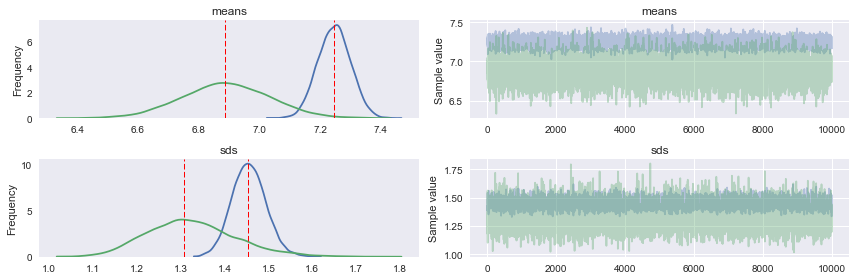

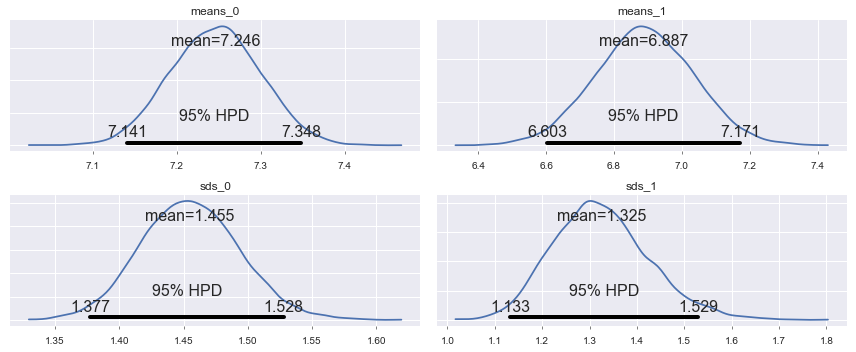

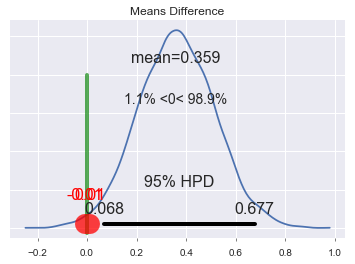

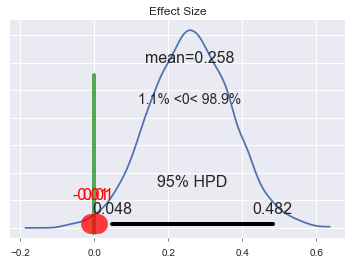

In [16]:
byhabit = df.groupby('habit')['weight']
pd.DataFrame(byhabit.describe()).T

ax = pm.traceplot(trace_means, varnames=['means', 'sds'])
_ = ax[0][0].axvline(x=byhabit.mean()['smoker'],    linewidth=1, linestyle='dashed', color='r')
_ = ax[0][0].axvline(x=byhabit.mean()['nonsmoker'], linewidth=1, linestyle='dashed', color='r')
_ = ax[1][0].axvline(x=byhabit.std()['smoker'],     linewidth=1, linestyle='dashed', color='r')
_ = ax[1][0].axvline(x=byhabit.std()['nonsmoker'],  linewidth=1, linestyle='dashed', color='r')

_ = pm.plot_posterior(trace_means, kde_plot=True, alpha_level=0.05)

means_diff = trace_means['means'][:,0] - trace_means['means'][:,1]
ax = pm.plot_posterior(means_diff, kde_plot=True, ref_val=0, rope=(-0.01, 0.01))
ax.set_title('Means Difference')
#_ = pm.forestplot(trace_means, varnames=['means'])

eff_size = means_diff / np.sqrt( (trace_means['sds'][:,0] **2 + trace_means['sds'][:,1] **2) /2 )
ax = pm.plot_posterior(eff_size, kde_plot=True, ref_val=0, rope=(-0.01, 0.01))
_ = ax.set_title('Effect Size')

pm.df_summary(trace_means)

cohen_d = ( means_diff / np.sqrt( trace_means['sds'][:,0]**2 + trace_means['sds'][:,1]**2 ) ).mean()
prob_superiority = stats.norm.cdf(cohen_d / 2**0.5)
(cohen_d, prob_superiority)

In [ ]:
# Question 4
np.random.seed(1)
with pm.Model() as weeks:
    mu = pm.Uniform('mu', min(df.weeks), max(df.weeks))
    sigma = pm.HalfNormal('sigma', sd=df.weeks.std())
    y = pm.Normal('y', mu=mu, sd=sigma, observed=df.weeks)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_weeks = pm.sample(12000, step=step, start=start)
    trace_weeks = trace_weeks[2000:]

In [ ]:
_ = pm.traceplot(trace_weeks, lines={'mu': df.weeks.mean(), 'sigma': df.weeks.std()})
_ = pm.plot_posterior(trace_weeks, kde_plot=True, alpha_level=0.01)

pm.df_summary(trace_weeks, alpha=0.01)
pd.DataFrame(df.weeks.describe()).T

In [ ]:
# Question 5
np.random.seed(1)
with pm.Model() as gained:
    mu = pm.Uniform('mu', min(df.gained), max(df.gained))
    sigma = pm.HalfNormal('sigma', sd=df.gained.std())
    y = pm.Normal('y', mu=mu, sd=sigma, observed=df.gained)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_gained = pm.sample(12000, step=step, start=start)
    trace_gained = trace_gained[2000:]

In [ ]:
_ = pm.traceplot(trace_gained, lines={'mu': df.gained.mean(), 'sigma': df.gained.std()})
_ = pm.plot_posterior(trace_gained, kde_plot=True, alpha_level=0.05)

pm.df_summary(trace_gained, alpha=0.05)
pd.DataFrame(df.gained.describe()).T

### FIT5197 Assessment 4

In [ ]:
df = pd.read_csv('dataLOW3.csv')

In [ ]:
np.random.seed(1)
with pm.Model() as m_glm:
    pm.glm.glm('BWT ~ SMOKE', df)
    trace_glm = pm.sample(5000)
    trace_glm = trace_glm[1000:]

In [ ]:
coefs = pm.df_summary(trace_glm, alpha=0.05)['mean']
_ = pm.traceplot(trace_glm, lines={'Intercept': coefs.Intercept, 'SMOKE': coefs.SMOKE, 'sd': coefs.sd})
_ = pm.plot_posterior(trace_glm, kde_plot=True, alpha_level=0.05)

pm.df_summary(trace_glm, alpha=0.05)
pd.DataFrame(df.BWT.describe()).T

pm.hpd(trace_glm)

In [ ]:
np.random.seed(1)
with pm.Model() as m_glm1:
    pm.glm.glm('LOW ~ PTL + LWT + HT + UI + SMOKE + RACE + PTL:UI + LWT:UI', 
               df, family=pm.glm.families.Binomial())
    trace_glm1 = pm.sample(12000)
    trace_glm1 = trace_glm1[2000:]
    
with pm.Model() as m_glm2:
    pm.glm.glm('LOW ~ PTL + LWT + HT + UI + SMOKE + RACE',
               df, family=pm.glm.families.Binomial())
    trace_glm2 = pm.sample(12000)
    trace_glm2 = trace_glm2[2000:]

In [ ]:
coefs1 = pm.df_summary(trace_glm1, alpha=0.05)['mean']
_ = pm.traceplot(trace_glm1) #, lines={'Intercept': coefs.Intercept, 'SMOKE': coefs.SMOKE, 'sd': coefs.sd})
_ = pm.plot_posterior(trace_glm1, kde_plot=True, alpha_level=0.05)

pm.df_summary(trace_glm1, alpha=0.05)

pm.stats.dic(trace_glm1, m_glm1)
pm.stats.waic(trace=trace_glm1, model=m_glm1)

In [ ]:
coefs2 = pm.df_summary(trace_glm2, alpha=0.05)['mean']
_ = pm.traceplot(trace_glm2) #, lines={'Intercept': coefs.Intercept, 'SMOKE': coefs.SMOKE, 'sd': coefs.sd})
_ = pm.plot_posterior(trace_glm2, kde_plot=True, alpha_level=0.05)

pm.df_summary(trace_glm2, alpha=0.05)

pm.stats.dic(trace_glm2, m_glm2)
pm.stats.waic(trace=trace_glm2, model=m_glm2)